In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)

In [2]:
# Adapated from: https://colab.research.google.com/drive/1EO0bS0Wow_cjdGsDfV38xt--AxJQjFtg?usp=sharing#scrollTo=qmZ1uZecv7qW
# Use conda env py39
import pandas

from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, check_max_local_length, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
import torch
import random
import numpy as np
from sentence_transformers import SentenceTransformer

from nltk.corpus import stopwords as stop_words

from collections import Counter

In [3]:

def fix_seeds():
    torch.manual_seed(10)
    torch.cuda.manual_seed(10)
    np.random.seed(10)
    random.seed(10)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

In [5]:
df = pandas.read_csv("topic-modeling-code/russia_ukraine_vk_war_only.csv")
df

In [7]:
# Preprocessing
documents = [str(x) for x in df.text.tolist()]

# nltk.download('stopwords')
stopwords = list(set(stop_words.words('russian')))
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords, max_df=0.995)
preprocessed_documents, unpreprocessed_corpus, vocab, _ = sp.preprocess()

fix_seeds() # uncomment if you don't want to fix the random seeds
    
# Train model with multilingual sentence model
tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")

# Extact the embeddings ourselves so we can reduce the batch size enough to fit on old GPUs
custom_embeddings = bert_embeddings_from_list(unpreprocessed_corpus, tp.contextualized_model, batch_size=8, max_seq_length=tp.max_seq_length)
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents, custom_embeddings = custom_embeddings)

num_topics = 30
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=50)
ctm.fit(training_dataset) # run the model

/homes/gws/chentong/anaconda3/envs/pt-hw-pro/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 1808 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/12639 [00:00<?, ?it/s]

Epoch: [50/50]	 Seen Samples: [5052800/5055400]	Train Loss: 114.82864403558578	Time: 0:00:10.503172: : 50it [08:37, 10.36s/it]
100%|██████████| 1580/1580 [00:05<00:00, 295.77it/s]


In [12]:
print(ctm.get_topic_lists(5))

[['информации', 'россииским', 'иностранного', 'функции', 'иностранным'], ['gs', 'amp', 'москве', 'петербурге', 'победы'], ['компании', 'евро', 'нефти', 'компания', 'цены'], ['life', 'tv', 'важное', 'ria', 'заявление'], ['обсе', 'феики', 'rutube', 'cnn', 'призывы'], ['go', 'tass', 'http', 'ru', 'тасс'], ['html', 'https', 'www', 'utm', 'это'], ['минобороны', 'военнои', 'оперативно', 'объектов', 'операции'], ['com', 'rt', 'подробнее', 'russian', 'world'], ['utm', 'подробности', 'smotrim', 'новости', 'video'], ['заявил', 'владимир', 'нато', 'сша', 'президент'], ['мариуполя', 'обстрелов', 'жители', 'корреспондент', 'обстрела']]


In [9]:
topics_predictions = ctm.training_doc_topic_distributions # get all the topic predictions
print(len(topics_predictions))

101108


In [10]:
train_doc_id = 0
topic_id = np.argmax(topics_predictions[train_doc_id]) # get the topic id of the  document
print(ctm.get_topic_lists(10)[topic_id])

['gs', 'amp', 'москве', 'петербурге', 'победы', 'отечественнои', 'санкт', 'новои', 'великои', 'лет']


In [11]:
# save ctm model to file ctm.pkl
import pickle
with open('ctm.pkl', 'wb') as f:
    pickle.dump(ctm, f)
    

In [24]:
military_word_set = set([
    # округа:area, авиации:aviation, военного:military, военно:military, флота:navy, 
    # учения:military exercise, су:Sukhoi Su, военнослужащие:military personnel, противника:enemy, сил:forces
    "округа", "авиации", "военного", "военно", "флота", 
    "учения", "су", "военнослужащие", "противника", "сил",
])
ukraine_word_set = set([
    # днр:DPR, лнр:LPR, мариуполя:Mariupol, мирных:peaceful, жителеи:residents, 
    # украинские:Ukrainian, народнои:folk, новости:news, донбасса:Donbass, мариуполе:Mariupol
    "днр", "лнр", "мариуполя", "мирных", "жителеи", 
    "украинские", "народнои", "новости", "донбасса", "мариуполе",
])
topic_word_set_list = [set(l) for l in ctm.get_topic_lists(100)]
# find the topic that contains the most military words
military_word_inter_size = [len(topic_word_set.intersection(military_word_set)) for topic_word_set in topic_word_set_list]
military_topic_idx = np.argmax(military_word_inter_size)
print(military_word_inter_size, military_topic_idx)
# # find the topic that contains the most ukraine words
ukraine_word_inter_size = [len(topic_word_set.intersection(ukraine_word_set)) for topic_word_set in topic_word_set_list]
ukraine_topic_idx = np.argmax(ukraine_word_inter_size)
print(ukraine_word_inter_size, ukraine_topic_idx)

[0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0] 7
[1, 0, 0, 0, 0, 1, 1, 0, 1, 4, 0, 5] 11


In [63]:
from tqdm.auto import tqdm
import pandas as pd

# counting the number of topic 11 with two kinds
topic_per_text = np.argmax(topics_predictions, axis=1)
# print(Counter(topic_per_text))

sub_df = df[['text', 'date', 'kind']].dropna()
print(sub_df.head())

results = []
for topic, (i, row) in tqdm(zip(topic_per_text, sub_df.iterrows())):
    results.append({'topic': topic, 'kind': row['kind']})
results = pandas.DataFrame(results)

                                                text  date              kind
0                                              ⚡ ⚡ ⚡   441  state-affiliated
1  Руководство УЕФА решило перенести игру из-за с...   420  state-affiliated
2  Российский теннисист поднялся на две позиции б...   493  state-affiliated
3  ❗ ️ Латвия запретила 25 российским деятелям ку...   447  state-affiliated
4  « Не верится , что всё это происходит » ➡ Подр...   424  state-affiliated


0it [00:00, ?it/s]

In [82]:
# compute the number of posts for each date for each kind
cnt_df_war = pd.DataFrame(results.groupby(['topic', 'kind']).size()).reset_index()
# print(cnt_df_war)
cnt_df_all = pd.DataFrame(results.groupby(['kind']).size()).reset_index()
# print(cnt_df_all)
cnt_df = cnt_df_war.merge(cnt_df_all, on='kind', suffixes=('_war', '_all'))
# # set nan to 0, and set all to float
# cnt_df = cnt_df.fillna(0).astype(float)
cnt_df['freq'] = cnt_df['0_war'] / cnt_df['0_all']
cnt_df

,topic,kind,0_war,0_all,freq
0,0,independent,2928,23111,0.126693
1,1,independent,5111,23111,0.221150
2,2,independent,3840,23111,0.166155
3,3,independent,91,23111,0.003938
4,4,independent,2081,23111,0.090044
5,5,independent,622,23111,0.026914
6,6,independent,2905,23111,0.125698
7,7,independent,773,23111,0.033447
8,8,independent,490,23111,0.021202
9,9,independent,270,23111,0.011683


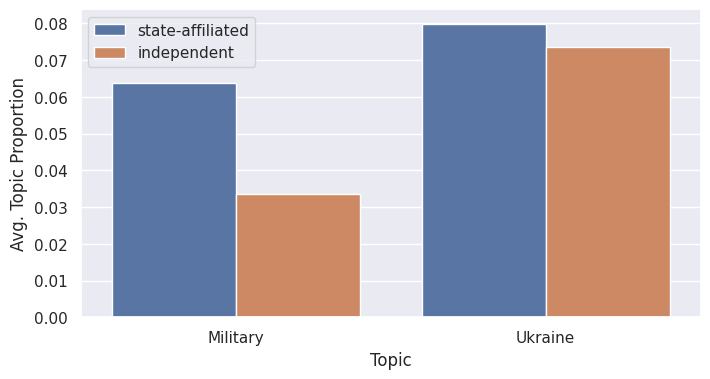

In [98]:
# seaborm bar plot of freq, group by type and hue by kind

import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
hue_order = ['state-affiliated', 'independent']
x_order = [military_topic_idx, ukraine_topic_idx]
g = sns.barplot(x="topic", y="freq", hue="kind", data=cnt_df[cnt_df['topic'].isin([military_topic_idx, ukraine_topic_idx])], hue_order=hue_order)
g.legend_.set_title("")
plt.ylabel('Avg. Topic Proportion')
plt.xlabel('Topic')
plt.xticks([0, 1], ['Military', 'Ukraine'])
plt.show()
fig.savefig("fig2.pdf", bbox_inches='tight')